# Falcons tutorial
The basic usageof Falcons is explained here. Let's declare the use of the package as follows.

In [3]:
using Revise
using Falcons
using Plots
using Healpix
using PyPlot
pyplot()

Plots.PyPlotBackend()

## ScanningStrategy struct
Falcons has a `ScanningStrategy` struct.
It can be generated using the `gen_Scanning_Strategy` function.
Let's declare it as `ss`.

In [4]:
ss = gen_ScanningStrategy()
show_ss(ss)

nside                    : 128 
duration [sec]           : 31536000.0 
sampling rate [Hz]       : 1.0 
alpha [deg]              : 45.0 
beta [deg]               : 50.0 
gamma [deg]              : 0.0 
prec. period [min]       : 192.348
↳ prec. rate [rpm]       : 0.005199
spin period [min]        : 20.000
↳ spin rate [rpm]        : 0.050000
HWP rot. rate[rpm]       : 0.000000 
start angle              : 0.000000 
coordinate system        : E 
FPU                     
↳ Det. 1  name | boresight              : (x,y,z,w) = [0.000, 0.000, 1.000, 0.000] 


The result of `show_ss(ss)` shows the parameters that ScanningStrategy contains.

Next, let's change the parameters of the `ScanningStrategy`.
There are two ways to change the value: by entering the value in the argument when declaring it, or by accessing ss later and changing it interactively.

In [6]:
# First method
#period2rpm(min) converts rotation period[min.] to rpm.
PrecessionPeriod_min = 4*60
ss = gen_ScanningStrategy(alpha=45, prec_rpm = period2rpm(PrecessionPeriod_min))

ScanningStrategy{Float64, Int64, String}(128, 31536000, 1.0, 45.0, 50.0, 0.0, 0.004166666666666667, 0.05, 0.0, "equator", 0.0, "E", [[0.0, 0.0, 1.0, 0.0]], ["boresight"], 0×0 DataFrame)

In [9]:
# Second method
ss.spin_rpm = 0.032
ss.beta = 50;

## How to calculate pointings
Plot the pointings drawn by the boresight in 1 period.
`time_array` contains the time used in the calculation.

In [ ]:
day = 60*60*24
time = [1000, 5000, 10000, 30day]
track = [HealpixMap{Float64, RingOrder}(ss.nside) for i in eachindex(time)]

for i in eachindex(time)
    pointings = get_pointings(ss, 0, time[i])
    track[i].pixels = angtod2hitmap(ss.nside, pointings[1], pointings[2])
end

plts = [Plots.plot(track[i], c=:viridis, title="duration="*"$(time[i]) sec.") for i in eachindex(time)]
Plots.plot(plts[1], plts[2], plts[3], plts[4], layout=(1,length(time)), size=(1400,300))

In [6]:
nmax = 5
outmap = get_hn_map(ss, division=6, nmax=nmax)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


Dict{String, Array} with 2 entries:
  "hitmap" => [310.0, 312.0, 314.0, 311.0, 391.0, 389.0, 386.0, 382.0, 388.0, 3…
  "h"      => ComplexF64[-0.00343144+0.139945im 0.392486-0.00140094im … 0.60358…

`outmap[1]` contains the result of the hitmap, as shown in the plot above.
`outmap[2]-[5]` contains the crosslink map corresponding to spin `n` as shown below.

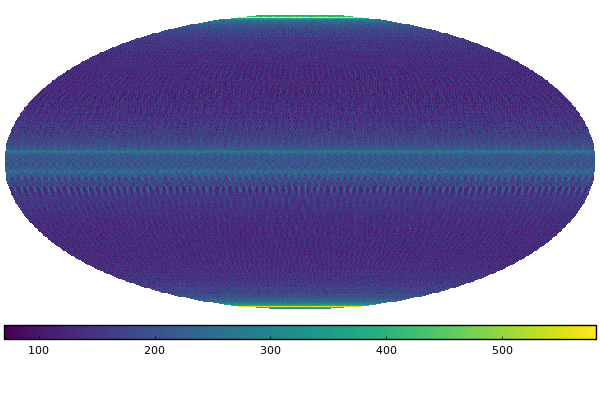

In [7]:
hitmap = HealpixMap{Float64, RingOrder}(ss.nside)
hitmap.pixels = outmap["hitmap"]
Plots.plot(hitmap, c=:viridis)

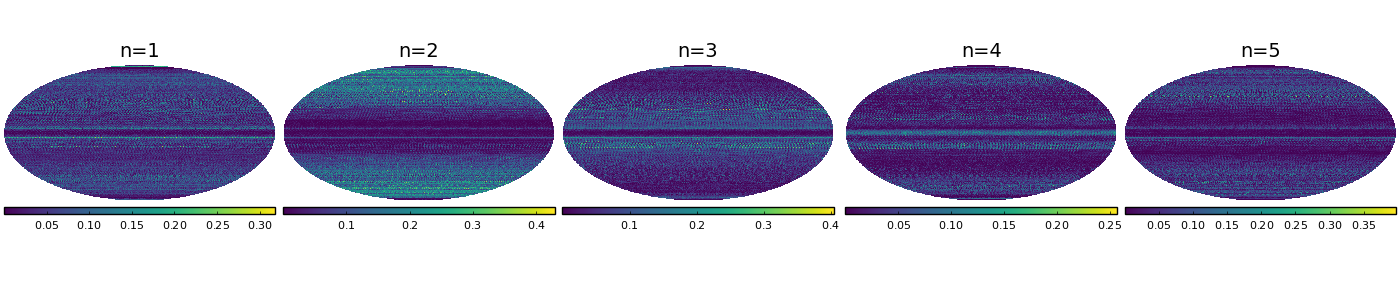

In [8]:
hmaps = [HealpixMap{Float64, RingOrder}(ss.nside) for i in 1:nmax]

for i in 1:nmax
    hmaps[i].pixels = outmap["h"][:,i] .|> abs2
end

hn_fig = [Plots.plot(hmaps[i], c=:viridis, title="n=$i") for i in 1:nmax]
    
Plots.plot(hn_fig[1], hn_fig[2], hn_fig[3], hn_fig[4], hn_fig[5], layout=(1,nmax), size=(1400,300))